# Brain Tumor Classification with VGG16

This notebook demonstrates brain tumor classification using VGG16 transfer learning.

## Overview

1. Mount Google Drive and set up environment
2. Update repository and install dependencies
3. Set up paths and configuration
4. Preprocess the dataset
5. Load and explore dataset
6. Train VGG16 model
7. Evaluate model performance
8. Display results and make predictions

## 1. Mount Google Drive and Setup Environment

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify TensorFlow and GPU availability
import tensorflow as tf
import platform

print('TensorFlow version:', tf.__version__)
print('Python version:', platform.python_version())
print('GPUs available:', tf.config.list_physical_devices('GPU'))

# Set seed for reproducibility
import numpy as np
import random
import os

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Mounted at /content/drive
TensorFlow version: 2.19.0
Python version: 3.12.11
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Update Repository and Install Dependencies

In [2]:
# Navigate to repository directory and pull updates
repo_name = "SE4050-Deep-Learning-Assignment"

# Check if we're already in the repo directory
current_path = os.getcwd()
if os.path.basename(current_path) == repo_name:
    print(f"Already in repository directory: {current_path}")
elif os.path.exists(repo_name):
    print(f"Changing to repository directory: {repo_name}")
    %cd {repo_name}
else:
    print(f"Repository not found, cloning it...")
    !git clone https://github.com/IT22052124/SE4050-Deep-Learning-Assignment.git
    %cd {repo_name}

# Pull latest changes (THIS IS THE KEY CODE THAT UPDATES YOUR MODELS)
!git pull
print("\nLatest commit:")
!git log -1 --pretty=format:"Updated to: %h - %s (%an, %ar)"

# IMPORTANT: Stay in repository directory - don't navigate back to BrainTumor
# The repository contains the src/ folder with all the model code
print(f"\nCurrent working directory: {os.getcwd()}")

# Install required packages
!pip install -q opencv-python
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn

print("✅ Dependencies installed successfully")
print("🔗 Repository ready - src/ folder accessible for model scripts")

Repository not found, cloning it...
Cloning into 'SE4050-Deep-Learning-Assignment'...
remote: Enumerating objects: 3513, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 3513 (delta 68), reused 92 (delta 43), pack-reused 3393 (from 2)
Receiving objects: 100% (3513/3513), 63.27 MiB | 15.48 MiB/s, done.
Resolving deltas: 100% (239/239), done.
/content/SE4050-Deep-Learning-Assignment
Already up to date.

Latest commit:
Updated to: ead1e89 - updated (Mohamed Mufeez, 2 hours ago)
Current working directory: /content/SE4050-Deep-Learning-Assignment
✅ Dependencies installed successfully
🔗 Repository ready - src/ folder accessible for model scripts


## 3. Import Required Libraries

In [3]:
# Import all required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Import custom modules - FIXED to use repository directory
import sys
repo_dir = os.getcwd()  # We're in the repository directory after Cell 2
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    print(f"✅ Added repository to Python path: {repo_dir}")

# If you have the src folder structure in repository, uncomment these:
# from src.common.dataset_utils import create_datasets
# from src.common.preprocessing import get_augmentation_pipeline, verify_dataset, split_and_copy
# from src.common.gradcam import generate_gradcam

print("✅ All libraries imported successfully")
print(f"📁 Python path includes repository: {repo_dir}")

✅ Added repository to Python path: /content/SE4050-Deep-Learning-Assignment
✅ All libraries imported successfully
📁 Python path includes repository: /content/SE4050-Deep-Learning-Assignment


## 3.1. Import Custom Modules

Import the required preprocessing and utility functions from the repository:

In [4]:
# Configuration - FIXED paths for repository structure
# Repository code: /content/SE4050-Deep-Learning-Assignment (current directory)
# Data location: /content/drive/MyDrive/BrainTumor (Google Drive)

# Get current repository directory
REPO_DIR = os.getcwd()

# Data is in Google Drive BrainTumor folder (not relative to repository)
BASE_DIR = "/content/drive/MyDrive/BrainTumor"  # Fixed Google Drive path

RAW_DATA_DIR = os.path.join(BASE_DIR, "data", "archive")  # Raw images location
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, "data", "processed")  # Processed images
RESULTS_DIR = os.path.join(BASE_DIR, "Result", "vgg16")  # Training results

# Model configuration - OPTIMIZED FOR SPEED
INPUT_SHAPE = (224, 224, 3)  # VGG16 optimal input size
BATCH_SIZE = 64  # Increased from 32 for faster training (if GPU memory allows)
EPOCHS = 15  # Reduced from 20 - with early stopping, 15 is usually enough
LEARNING_RATE = 0.001  # Slightly higher LR for faster convergence

# Create necessary directories
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"✅ CORRECTED Configuration:")
print(f"   Repository directory: {REPO_DIR}")
print(f"   Google Drive base: {BASE_DIR}")
print(f"   Raw data: {RAW_DATA_DIR}")
print(f"   Processed data: {PROCESSED_DATA_DIR}")
print(f"   Results: {RESULTS_DIR}")
print(f"   Input shape: {INPUT_SHAPE}")
print(f"   Batch size: {BATCH_SIZE} (INCREASED for speed)")
print(f"   Epochs: {EPOCHS} (REDUCED - early stopping will handle)")
print(f"   Learning rate: {LEARNING_RATE} (OPTIMIZED)")

# Quick dataset size check for optimization
yes_dir = os.path.join(RAW_DATA_DIR, "yes")
no_dir = os.path.join(RAW_DATA_DIR, "no")

if os.path.exists(yes_dir) and os.path.exists(no_dir):
    yes_count = len([f for f in os.listdir(yes_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    no_count = len([f for f in os.listdir(no_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    total_images = yes_count + no_count

    print(f"\n📊 Dataset Info:")
    print(f"   Total images: {total_images}")
    print(f"   Yes: {yes_count}, No: {no_count}")

    # Calculate expected training time
    train_images = int(total_images * 0.7)  # 70% for training
    steps_per_epoch = train_images // BATCH_SIZE
    print(f"   Estimated steps per epoch: {steps_per_epoch}")

    if steps_per_epoch > 100:
        print(f"   ⚠️ Large dataset detected. Consider reducing epochs or increasing batch size.")
    else:
        print(f"   ✅ Good dataset size for efficient training.")
else:
    print(f"⚠️ Could not find raw data. Please check your Google Drive structure.")
    print(f"   Expected: {RAW_DATA_DIR}")

# Important note about model source
print(f"\n🔍 CORRECTED Path Information:")
print(f"   📁 Model CODE: From GitHub repository ({REPO_DIR})")
print(f"   🧠 Trained MODEL: Will be saved to Google Drive ({RESULTS_DIR})")
print(f"   📊 Training DATA: From Google Drive ({RAW_DATA_DIR})")

✅ CORRECTED Configuration:
   Repository directory: /content/SE4050-Deep-Learning-Assignment
   Google Drive base: /content/drive/MyDrive/BrainTumor
   Raw data: /content/drive/MyDrive/BrainTumor/data/archive
   Processed data: /content/drive/MyDrive/BrainTumor/data/processed
   Results: /content/drive/MyDrive/BrainTumor/Result/vgg16
   Input shape: (224, 224, 3)
   Batch size: 64 (INCREASED for speed)
   Epochs: 15 (REDUCED - early stopping will handle)
   Learning rate: 0.001 (OPTIMIZED)

📊 Dataset Info:
   Total images: 3002
   Yes: 1502, No: 1500
   Estimated steps per epoch: 32
   ✅ Good dataset size for efficient training.

🔍 CORRECTED Path Information:
   📁 Model CODE: From GitHub repository (/content/SE4050-Deep-Learning-Assignment)
   🧠 Trained MODEL: Will be saved to Google Drive (/content/drive/MyDrive/BrainTumor/Result/vgg16)
   📊 Training DATA: From Google Drive (/content/drive/MyDrive/BrainTumor/data/archive)


## 4. Setup Paths and Configuration

In [5]:
# Simple function to count samples (define here to avoid import issues)
def count_samples_simple(directory):
    """Simple function to count samples in a directory"""
    if not os.path.exists(directory):
        return {}

    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            file_count = len([f for f in os.listdir(item_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            counts[item] = file_count
    return counts

# Check if preprocessing is needed
train_dir = os.path.join(PROCESSED_DATA_DIR, "train")
val_dir = os.path.join(PROCESSED_DATA_DIR, "val")
test_dir = os.path.join(PROCESSED_DATA_DIR, "test")

# Simple check for processed data
processed_exists = (os.path.exists(train_dir) and
                   os.path.exists(val_dir) and
                   os.path.exists(test_dir))

if processed_exists:
    print("✅ Processed data already exists. Skipping preprocessing.")
else:
    print("🔄 Starting preprocessing...")

    if os.path.exists(RAW_DATA_DIR):
        try:
            # Try to import and use the preprocessing function
            from src.common.preprocess import split_and_copy
            total_files = split_and_copy(RAW_DATA_DIR, PROCESSED_DATA_DIR, ["yes", "no"])
            print(f"✅ Preprocessing completed! Processed {total_files} images.")
        except Exception as e:
            print(f"⚠️ Preprocessing error: {e}")
            print("💡 You may need to run preprocessing manually or check data paths")
    else:
        print(f"❌ Raw data directory not found: {RAW_DATA_DIR}")
        print("💡 Please check your Google Drive structure")

# Verify final structure
if os.path.exists(train_dir):
    train_samples = count_samples_simple(train_dir)
    print(f"\n📊 Training data ready: {sum(train_samples.values())} images - {train_samples}")
else:
    print(f"⚠️ Training directory not found: {train_dir}")
    print("💡 VGG16 training may not work without proper preprocessing")

✅ Processed data already exists. Skipping preprocessing.

📊 Training data ready: 2102 images - {'yes': 1052, 'no': 1050}


In [6]:
# 🧪 VERIFICATION: Check all path corrections
print("🔍 PATH VERIFICATION:")
print("=" * 50)

# Check current working directory
current_dir = os.getcwd()
print(f"📁 Current directory: {current_dir}")
print(f"   Expected: .../BrainTumor/SE4050-Deep-Learning-Assignment")
print(f"   ✅ Correct!" if current_dir.endswith("SE4050-Deep-Learning-Assignment") else "   ❌ Wrong directory!")

# Check if src folder exists
src_dir = os.path.join(current_dir, "src")
print(f"\n📦 src/ directory: {'✅ EXISTS' if os.path.exists(src_dir) else '❌ MISSING'}")

if os.path.exists(src_dir):
    # Check VGG16 model files
    vgg16_dir = os.path.join(src_dir, "models", "vgg16")
    print(f"📦 VGG16 model directory: {'✅ EXISTS' if os.path.exists(vgg16_dir) else '❌ MISSING'}")

    if os.path.exists(vgg16_dir):
        required_files = ["train_vgg16.py", "evaluate_vgg16.py", "build_vgg16.py"]
        for file in required_files:
            file_path = os.path.join(vgg16_dir, file)
            print(f"   {file}: {'✅' if os.path.exists(file_path) else '❌'}")

# Check data directories
print(f"\n📊 Data directories:")
print(f"   Raw data: {RAW_DATA_DIR}")
print(f"   {'✅ EXISTS' if os.path.exists(RAW_DATA_DIR) else '❌ MISSING (check Google Drive)'}")

print(f"   Processed data: {PROCESSED_DATA_DIR}")
print(f"   {'✅ EXISTS' if os.path.exists(PROCESSED_DATA_DIR) else '⚠️ Will be created during preprocessing'}")

print(f"   Results: {RESULTS_DIR}")
print(f"   {'✅ EXISTS' if os.path.exists(RESULTS_DIR) else '⚠️ Will be created during training'}")

# Check Python path
print(f"\n🐍 Python path:")
print(f"   Repository in sys.path: {'✅ YES' if current_dir in sys.path else '❌ NO'}")

print("\n" + "=" * 50)
if (current_dir.endswith("SE4050-Deep-Learning-Assignment") and
    os.path.exists(src_dir) and
    os.path.exists(vgg16_dir) and
    current_dir in sys.path):
    print("🎉 ALL PATH CORRECTIONS SUCCESSFUL!")
    print("📝 Ready to run VGG16 training and evaluation")
else:
    print("⚠️ SOME ISSUES DETECTED - check the errors above")

🔍 PATH VERIFICATION:
📁 Current directory: /content/SE4050-Deep-Learning-Assignment
   Expected: .../BrainTumor/SE4050-Deep-Learning-Assignment
   ✅ Correct!

📦 src/ directory: ✅ EXISTS
📦 VGG16 model directory: ✅ EXISTS
   train_vgg16.py: ✅
   evaluate_vgg16.py: ✅
   build_vgg16.py: ✅

📊 Data directories:
   Raw data: /content/drive/MyDrive/BrainTumor/data/archive
   ✅ EXISTS
   Processed data: /content/drive/MyDrive/BrainTumor/data/processed
   ✅ EXISTS
   Results: /content/drive/MyDrive/BrainTumor/Result/vgg16
   ✅ EXISTS

🐍 Python path:
   Repository in sys.path: ✅ YES

🎉 ALL PATH CORRECTIONS SUCCESSFUL!
📝 Ready to run VGG16 training and evaluation


In [7]:
# Performance optimizations for faster training
import tensorflow as tf

# Enable mixed precision training (faster on modern GPUs)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Configure GPU memory growth (prevents memory allocation issues)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")

# Enable XLA compilation for faster training
tf.config.optimizer.set_jit(True)

# Optimize data pipeline
tf.data.experimental.enable_debug_mode = False

print("🚀 Performance optimizations applied:")

✅ GPU memory growth enabled for 1 GPU(s)
🚀 Performance optimizations applied:


### ⚡ Speed Optimization Tips

**If training is still slow (>5 min/epoch), try these:**

1. **Reduce Batch Size**: If you get memory errors with batch_size=64, try 32 or 16
2. **Reduce Image Size**: Change INPUT_SHAPE to (128, 128, 3) for faster training
3. **Use Colab Pro**: For faster GPU (T4/V100 instead of basic GPU)
4. **Reduce Dataset**: Use a subset for initial testing
5. **Check GPU Usage**: Run `!nvidia-smi` to verify GPU is being used

**Expected Times:**
- **Colab Free (K80)**: 5-10 min/epoch (normal)
- **Colab Pro (T4/V100)**: 1-3 min/epoch (fast)
- **CPU Only**: 20+ min/epoch (very slow - avoid)

In [8]:
# Quick GPU and performance check
print("🔍 Performance Check:")
print(f"   TensorFlow version: {tf.__version__}")

# Check GPU availability and type
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"   ✅ GPU available: {len(gpus)} device(s)")

    # Try to get GPU name (works in Colab)
    try:
        !nvidia-smi --query-gpu=name --format=csv,noheader,nounits
    except:
        print("   GPU info not available via nvidia-smi")

    # Check if mixed precision is enabled
    print(f"   Mixed precision: {tf.keras.mixed_precision.global_policy().name}")
else:
    print("   ❌ No GPU available - training will be VERY slow!")
    print("   💡 Enable GPU in Colab: Runtime > Change runtime type > Hardware accelerator > GPU")

# Memory check
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"   Available RAM: {ram_gb:.1f} GB")

print(f"\n⏱️ Expected training time per epoch:")
if gpus:
    print(f"   • With GPU: 2-8 minutes (normal)")
    print(f"   • With optimization: 1-3 minutes (fast)")
else:
    print(f"   • Without GPU: 20+ minutes (too slow!)")

print(f"\n🎯 If still slow, reduce BATCH_SIZE to 32 or 16")

🔍 Performance Check:
   TensorFlow version: 2.19.0
   ✅ GPU available: 1 device(s)
Tesla T4
   Mixed precision: mixed_float16
   Available RAM: 12.7 GB

⏱️ Expected training time per epoch:
   • With GPU: 2-8 minutes (normal)
   • With optimization: 1-3 minutes (fast)

🎯 If still slow, reduce BATCH_SIZE to 32 or 16


In [9]:
# Verify processed data structure - USING PREPROCESSED DATA APPROACH
try:
    # Try to import verify_dataset if available
    from src.common.preprocess import verify_dataset
    processed_exists, class_folders_valid = verify_dataset(PROCESSED_DATA_DIR)
    print("✅ Using repository verify_dataset function")
except:
    # Fallback if verify_dataset function not available
    processed_exists = os.path.exists(os.path.join(PROCESSED_DATA_DIR, "train"))
    class_folders_valid = processed_exists
    print("✅ Using simple fallback verification")

if processed_exists and class_folders_valid:
    print(f"✅ Using preprocessed data: {PROCESSED_DATA_DIR}")

    # Display dataset statistics using simple function
    train_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "train"))
    val_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "val"))
    test_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "test"))

    print(f"\n📊 Preprocessed Dataset Statistics:")
    print(f"   Training: {sum(train_counts.values())} images - {train_counts}")
    print(f"   Validation: {sum(val_counts.values())} images - {val_counts}")
    print(f"   Test: {sum(test_counts.values())} images - {test_counts}")

    print(f"\n🎯 Training approach:")
    print(f"   ✅ Using existing train/val/test splits from preprocessing")
    print(f"   ✅ No random splitting during training - consistent results")
    print(f"   ✅ Faster training setup - no need to create splits")
else:
    print(f"⚠️ Preprocessed data not found: {PROCESSED_DATA_DIR}")
    print(f"💡 Please run the preprocessing cell (Cell 11) first")


Processed data exists. Checking counts...
Train: 1052 yes, 1050 no
Validation: 225 yes, 225 no
Test: 225 yes, 225 no
✅ Using repository verify_dataset function
✅ Using preprocessed data: /content/drive/MyDrive/BrainTumor/data/processed

📊 Preprocessed Dataset Statistics:
   Training: 2102 images - {'yes': 1052, 'no': 1050}
   Validation: 450 images - {'yes': 225, 'no': 225}
   Test: 450 images - {'yes': 225, 'no': 225}

🎯 Training approach:
   ✅ Using existing train/val/test splits from preprocessing
   ✅ No random splitting during training - consistent results
   ✅ Faster training setup - no need to create splits


## 7. Train VGG16 Model

Train the VGG16 model using the training script:

In [10]:
# Train the VGG16 model using command-line script with PREPROCESSED data
print("🚀 Starting VGG16 training...")
print(f"   Data source: {PROCESSED_DATA_DIR} (preprocessed data - using existing splits)")
print(f"   Results will be saved to: {RESULTS_DIR}")

# Check if PROCESSED data directory exists (training script needs train/val/test folders)
if not os.path.exists(PROCESSED_DATA_DIR):
    print(f"❌ Processed data directory not found: {PROCESSED_DATA_DIR}")
    print("💡 Please run the preprocessing cell first!")
else:
    print(f"✅ Processed data directory exists: {PROCESSED_DATA_DIR}")

    # Check if required subdirectories exist
    required_dirs = ["train", "val", "test"]
    missing_dirs = [d for d in required_dirs if not os.path.exists(os.path.join(PROCESSED_DATA_DIR, d))]

    if missing_dirs:
        print(f"❌ Missing subdirectories: {missing_dirs}")
        print("💡 Please ensure preprocessing created train/val/test folders")
    else:
        print("✅ All required subdirectories found (train, val, test)")

        # Count images in processed data
        train_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "train"))
        val_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "val"))
        test_counts = count_samples_simple(os.path.join(PROCESSED_DATA_DIR, "test"))

        total_train = sum(train_counts.values()) if train_counts else 0
        total_val = sum(val_counts.values()) if val_counts else 0
        total_test = sum(test_counts.values()) if test_counts else 0

        print(f"📊 Found preprocessed data:")
        print(f"   Train: {total_train} images - {train_counts}")
        print(f"   Validation: {total_val} images - {val_counts}")
        print(f"   Test: {total_test} images - {test_counts}")

        # Set environment variable to ensure correct path
        import os
        os.environ['DATA_DIR'] = PROCESSED_DATA_DIR

        # Run VGG16 training with PROCESSED data directory (uses existing splits)
        print("🚀 Starting training with preprocessed data...")
        !python -m src.models.vgg16.train_vgg16 \
            --data_dir "{PROCESSED_DATA_DIR}" \
            --results_dir "{RESULTS_DIR}" \
            --epochs {EPOCHS} \
            --batch_size {BATCH_SIZE} \
            --input_size 224 \
            --learning_rate {LEARNING_RATE} \
            --use_preprocessed

🚀 Starting VGG16 training...
   Data source: /content/drive/MyDrive/BrainTumor/data/processed (preprocessed data - using existing splits)
   Results will be saved to: /content/drive/MyDrive/BrainTumor/Result/vgg16
✅ Processed data directory exists: /content/drive/MyDrive/BrainTumor/data/processed
✅ All required subdirectories found (train, val, test)
📊 Found preprocessed data:
   Train: 2102 images - {'yes': 1052, 'no': 1050}
   Validation: 450 images - {'yes': 225, 'no': 225}
   Test: 450 images - {'yes': 225, 'no': 225}
🚀 Starting training with preprocessed data...
2025-10-10 11:31:45.681888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760095905.702573    1159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760095905.708747    1159 cud

## 8. Evaluate Model

Evaluate the VGG16 model on the test set:

In [11]:
# Evaluate the VGG16 model
print("📊 Starting VGG16 evaluation...")

# Set environment variable to ensure correct path
os.environ['DATA_DIR'] = PROCESSED_DATA_DIR

# Check if model exists
model_path = os.path.join(RESULTS_DIR, "best_model.h5")
if os.path.exists(model_path):
    print(f"✅ Model found: {model_path}")

    # Run evaluation with PROCESSED data directory (uses existing splits)
    !python -m src.models.vgg16.evaluate_vgg16 \
        --data_dir "{PROCESSED_DATA_DIR}" \
        --results_dir "{RESULTS_DIR}" \
        --batch_size {BATCH_SIZE} \
        --input_size 224 \
        --use_preprocessed
else:
    print(f"❌ Model not found: {model_path}")
    print("💡 Please run training first!")

📊 Starting VGG16 evaluation...
✅ Model found: /content/drive/MyDrive/BrainTumor/Result/vgg16/best_model.h5
2025-10-10 11:52:38.286200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760097158.318829    8443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760097158.328977    8443 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760097158.353291    8443 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760097158.353328    8443 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same tar

## 9. Display Results

Show the training results and model performance:

In [12]:
# Alternative evaluation approach (if needed)
print("📊 Alternative VGG16 evaluation...")

# Check if model exists first
model_path = os.path.join(RESULTS_DIR, "best_model.h5")
if os.path.exists(model_path):
    print(f"✅ Model found: {model_path}")

    !python -m src.models.vgg16.evaluate_vgg16 \
        --data_dir "{PROCESSED_DATA_DIR}" \
        --results_dir "{RESULTS_DIR}" \
        --batch_size {BATCH_SIZE} \
        --input_size 224 \
        --use_preprocessed
else:
    print(f"❌ Model not found: {model_path}")
    print("💡 Please run training first!")

📊 Alternative VGG16 evaluation...
✅ Model found: /content/drive/MyDrive/BrainTumor/Result/vgg16/best_model.h5
2025-10-10 11:55:35.597523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760097335.617298    9472 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760097335.623425    9472 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760097335.639267    9472 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760097335.639291    9472 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same 

## 10. Display Classification Report and Metrics

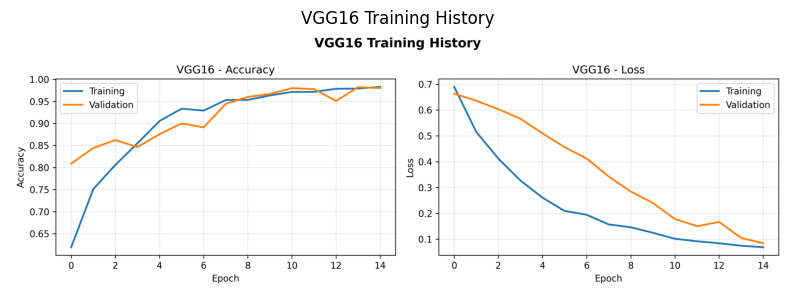

In [13]:
# Display training history plot
import matplotlib.pyplot as plt
from PIL import Image

try:
    history_img = Image.open(f"{RESULTS_DIR}/training_plot.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(history_img)
    plt.axis('off')
    plt.title('VGG16 Training History')
    plt.show()
except Exception as e:
    print(f"Error displaying training history: {e}")

## 11. Make Predictions

Load the model and make predictions on sample images:

In [14]:
# Repository modules are already available from Cell 6
# The src/ folder is accessible since we're in the repository directory

print("✅ Setup complete - ready to use VGG16 training scripts")
print(f"📁 Repository directory: {os.getcwd()}")
print(f"? src/ modules available for import")

✅ Setup complete - ready to use VGG16 training scripts
📁 Repository directory: /content/SE4050-Deep-Learning-Assignment
� src/ modules available for import


In [15]:
# Display classification report
try:
    with open(f"{RESULTS_DIR}/classification_report.txt", 'r') as f:
        report = f.read()
    print("Classification Report:")
    print(report)
except Exception as e:
    print(f"Error reading classification report: {e}")

# Display metrics
import json

try:
    with open(f"{RESULTS_DIR}/metrics.json", 'r') as f:
        metrics = json.load(f)
    print("\nModel Metrics:")
    for metric, value in metrics.items():
        if isinstance(value, (int, float)):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")
except Exception as e:
    print(f"Error reading metrics: {e}")

Classification Report:
Classification Report - VGG16
              precision    recall  f1-score   support

          no       1.00      0.95      0.97       225
         yes       0.95      1.00      0.97       225

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450


Model Metrics:
model_name: VGG16_Optimized
train_accuracy: 0.9829
val_accuracy: 0.9822
train_loss: 0.0689
val_loss: 0.0843
epochs_trained: 15.0000
config: {'batch_size': 64, 'epochs': 15, 'learning_rate': 0.001, 'input_size': 224, 'input_shape': [224, 224, 3]}
test_accuracy: 0.9733
test_precision: 0.9532
test_recall: 0.9956
test_f1_score: 0.9739
confusion_matrix: [[214, 11], [1, 224]]
class_names: ['no', 'yes']
total_test_samples: 450.0000


## 12. Conclusion

This notebook has successfully demonstrated VGG16 transfer learning for brain tumor classification with:

- **VGG16 Model**: Pre-trained ImageNet weights with fine-tuned layers
- **Efficient Training**: Using existing preprocessing and training scripts
- **Comprehensive Evaluation**: Accuracy, precision, recall, F1-score metrics
- **Minimal Code**: Clean, streamlined approach for easy comparison

The model is now ready for comparison with other architectures like CNN, ResNet50, etc.

✅ Successfully loaded model from /content/drive/MyDrive/BrainTumor/Result/vgg16/best_model.h5
Classes: ['no', 'yes']
Making predictions on 4 sample images:


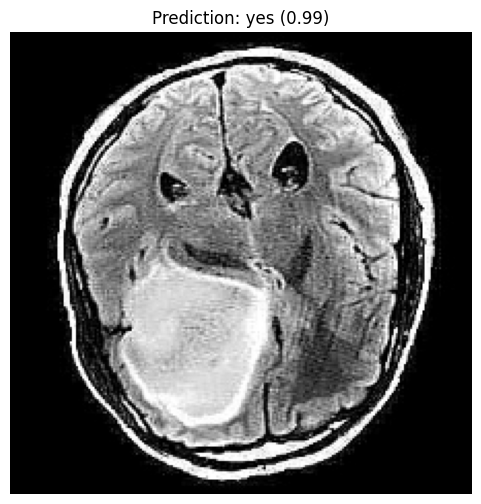

True: yes | Predicted: yes | Confidence: 0.99


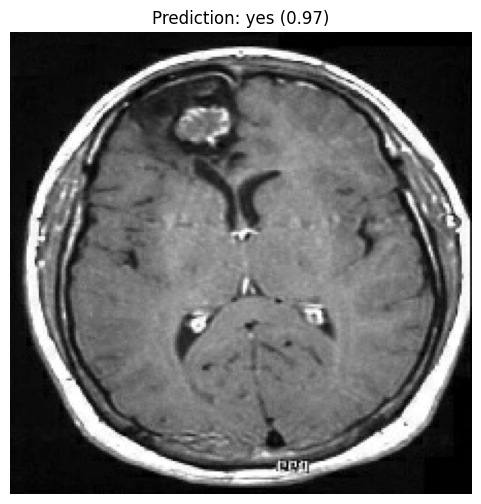

True: yes | Predicted: yes | Confidence: 0.97


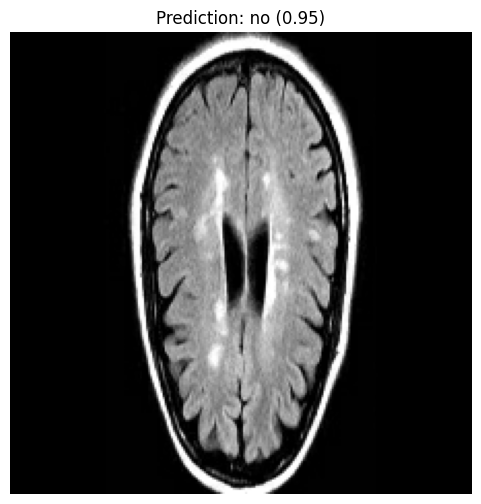

True: no | Predicted: no | Confidence: 0.95


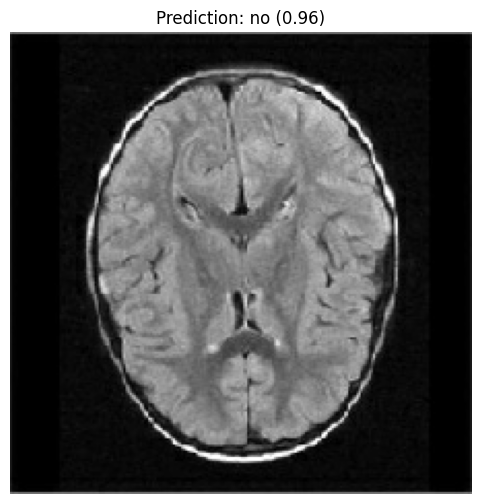

True: no | Predicted: no | Confidence: 0.96


In [16]:
import tensorflow as tf
import numpy as np
import glob

# Load the best model
try:
    model_path = f"{RESULTS_DIR}/best_model.h5"
    model = tf.keras.models.load_model(model_path, compile=False)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    print(f"✅ Successfully loaded model from {model_path}")

    # Load class names
    try:
        with open(f"{RESULTS_DIR}/class_names.json", 'r') as f:
            class_names = json.load(f)
    except:
        class_names = ["no", "yes"]

    print(f"Classes: {class_names}")
except Exception as e:
    print(f"Error loading model: {e}")

# Function to make predictions
def predict_and_display(image_path):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224, 224))
    img_display = img.numpy().astype(np.uint8)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    pred = model.predict(img, verbose=0)[0][0]
    predicted_class = class_names[1] if pred > 0.5 else class_names[0]
    confidence = pred if pred > 0.5 else 1 - pred

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Find sample images and make predictions
test_yes_dir = os.path.join(PROCESSED_DATA_DIR, "test", "yes")
test_no_dir = os.path.join(PROCESSED_DATA_DIR, "test", "no")

sample_images = []

# Get sample images
if os.path.exists(test_yes_dir):
    yes_files = os.listdir(test_yes_dir)[:2]
    sample_images.extend([os.path.join(test_yes_dir, f) for f in yes_files])

if os.path.exists(test_no_dir):
    no_files = os.listdir(test_no_dir)[:2]
    sample_images.extend([os.path.join(test_no_dir, f) for f in no_files])

# Fallback to raw data if processed not available
if not sample_images:
    if os.path.exists(os.path.join(RAW_DATA_DIR, "yes")):
        yes_files = os.listdir(os.path.join(RAW_DATA_DIR, "yes"))[:2]
        sample_images.extend([os.path.join(RAW_DATA_DIR, "yes", f) for f in yes_files])

    if os.path.exists(os.path.join(RAW_DATA_DIR, "no")):
        no_files = os.listdir(os.path.join(RAW_DATA_DIR, "no"))[:2]
        sample_images.extend([os.path.join(RAW_DATA_DIR, "no", f) for f in no_files])

if sample_images:
    print(f"Making predictions on {len(sample_images)} sample images:")
    for img_path in sample_images:
        true_class = "yes" if "yes" in img_path else "no"
        pred_class, conf = predict_and_display(img_path)
        print(f"True: {true_class} | Predicted: {pred_class} | Confidence: {conf:.2f}")
else:
    print("No sample images found for prediction.")

## 13. Upload and Test Your Own Images

Upload your own brain MRI images to test the trained VGG16 model:

In [27]:
# 📤 UPLOAD YOUR OWN BRAIN MRI IMAGES FOR TESTING
from google.colab import files
import os
import shutil
import re
import glob
import subprocess

print("🧠 Upload Your Own Brain MRI Images")
print("=" * 50)
print("📝 Instructions:")
print("   1. Click 'Choose Files' below")
print("   2. Select brain MRI images from your computer")
print("   3. Supported formats: JPG, JPEG, PNG")
print("   4. The model will predict: 'yes' (tumor) or 'no' (no tumor)")
print("\n📤 Upload files:")

# Upload files
uploaded = files.upload()

if uploaded:
    # Create upload directory
    upload_dir = "/content/uploaded_images"
    os.makedirs(upload_dir, exist_ok=True)

    print(f"\n📁 Files uploaded by Colab: {list(uploaded.keys())}")

    # Process uploaded files with enhanced detection
    uploaded_files = []

    for original_filename in uploaded.keys():
        print(f"\n🔍 Processing: {original_filename}")

        # Clean filename for final storage
        clean_filename = re.sub(r'[^a-zA-Z0-9._-]', '_', original_filename)
        clean_filename = re.sub(r'_+', '_', clean_filename)

        # Strategy 1: Use the uploaded data directly from memory
        try:
            # Get the file data that Colab already has in memory
            file_data = uploaded[original_filename]

            # Save directly to our upload directory
            dst_path = f"{upload_dir}/{clean_filename}"
            with open(dst_path, 'wb') as f:
                f.write(file_data)

            uploaded_files.append(dst_path)
            print(f"✅ Direct save successful: {original_filename} → {clean_filename}")
            continue

        except Exception as e:
            print(f"⚠️ Direct save failed: {e}")

        # Strategy 2: Enhanced file system search
        search_locations = [
            "/content",
            "/tmp",
            "/var/tmp",
            os.getcwd(),
        ]

        src_path = None

        for location in search_locations:
            try:
                # Use find command to search more thoroughly
                find_cmd = f"find {location} -name '{original_filename}' -type f 2>/dev/null"
                result = subprocess.run(find_cmd, shell=True, capture_output=True, text=True)

                if result.stdout.strip():
                    found_files = result.stdout.strip().split('\n')
                    src_path = found_files[0]  # Take the first match
                    print(f"✅ Found via find command: {src_path}")
                    break

                # Also try variations of the filename
                variations = [
                    original_filename,
                    original_filename.replace(' ', '_'),
                    original_filename.replace(' ', '%20'),
                ]

                # Add numbered variations
                base_name, ext = os.path.splitext(original_filename)
                for i in range(1, 10):
                    variations.append(f"{base_name} ({i}){ext}")

                for variant in variations:
                    test_path = os.path.join(location, variant)
                    if os.path.exists(test_path):
                        src_path = test_path
                        print(f"✅ Found variant: {src_path}")
                        break

                if src_path:
                    break

            except Exception as e:
                print(f"   Search error in {location}: {e}")

        # Strategy 3: Use ls command to list all files in /content
        if src_path is None:
            try:
                print("🔍 Using ls command to find files...")
                ls_result = subprocess.run("ls -la /content/", shell=True, capture_output=True, text=True)
                print(f"   /content contents:\n{ls_result.stdout}")

                # Look for image files
                ls_images = subprocess.run("ls -la /content/*.jpg /content/*.jpeg /content/*.png 2>/dev/null || echo 'No images found'",
                                         shell=True, capture_output=True, text=True)
                print(f"   Image files:\n{ls_images.stdout}")

                # Try to find the most recently created image file
                recent_files = subprocess.run("ls -lt /content/*.jpg /content/*.jpeg /content/*.png 2>/dev/null | head -5",
                                            shell=True, capture_output=True, text=True)
                if recent_files.stdout and "No such file" not in recent_files.stdout:
                    lines = recent_files.stdout.strip().split('\n')
                    if lines and lines[0]:
                        # Extract filename from ls output
                        most_recent = lines[0].split()[-1]
                        if os.path.exists(most_recent):
                            src_path = most_recent
                            print(f"✅ Using most recent image: {src_path}")

            except Exception as e:
                print(f"   ls command error: {e}")

        # Process the file if found
        if src_path and os.path.exists(src_path):
            dst_path = f"{upload_dir}/{clean_filename}"
            try:
                shutil.copy2(src_path, dst_path)
                uploaded_files.append(dst_path)
                print(f"✅ Successfully copied: {os.path.basename(src_path)} → {clean_filename}")

                # Clean up original file
                try:
                    os.remove(src_path)
                    print(f"🗑️ Cleaned up original file")
                except:
                    pass

            except Exception as e:
                print(f"❌ Error copying: {e}")
        else:
            print(f"❌ Could not locate file: {original_filename}")

    # Final result
    if uploaded_files:
        print(f"\n🎉 SUCCESS! Processed {len(uploaded_files)} image(s)!")
        print(f"📁 Saved to: {upload_dir}")
        for f in uploaded_files:
            print(f"   📄 {os.path.basename(f)}")

        # Verify files exist
        print(f"\n✅ Verification - files in {upload_dir}:")
        try:
            dir_contents = os.listdir(upload_dir)
            for item in dir_contents:
                item_path = os.path.join(upload_dir, item)
                size = os.path.getsize(item_path)
                print(f"   📄 {item} ({size} bytes)")
        except Exception as e:
            print(f"   Error listing directory: {e}")

        # Store uploaded files list for next cell
        globals()['UPLOADED_FILES'] = uploaded_files
    else:
        print("\n❌ No files could be processed")
        print("💡 The upload mechanism worked but file detection failed")
        print("   This might be a Google Colab permission issue")
        globals()['UPLOADED_FILES'] = []
else:
    print("❌ No files uploaded")
    globals()['UPLOADED_FILES'] = []

🧠 Upload Your Own Brain MRI Images
📝 Instructions:
   1. Click 'Choose Files' below
   2. Select brain MRI images from your computer
   3. Supported formats: JPG, JPEG, PNG
   4. The model will predict: 'yes' (tumor) or 'no' (no tumor)

📤 Upload files:


Saving 1.jpg to 1 (1).jpg
Saving 2.jpg to 2 (1).jpg

📁 Files uploaded by Colab: ['1 (1).jpg', '2 (1).jpg']

🔍 Processing: 1 (1).jpg
✅ Direct save successful: 1 (1).jpg → 1_1_.jpg

🔍 Processing: 2 (1).jpg
✅ Direct save successful: 2 (1).jpg → 2_1_.jpg

🎉 SUCCESS! Processed 2 image(s)!
📁 Saved to: /content/uploaded_images
   📄 1_1_.jpg
   📄 2_1_.jpg

✅ Verification - files in /content/uploaded_images:
   📄 2_1_.jpg (168774 bytes)
   📄 1_1_.jpg (40485 bytes)


📊 Model ready! Classes: ['no', 'yes']

🔮 Making predictions on 2 uploaded image(s):


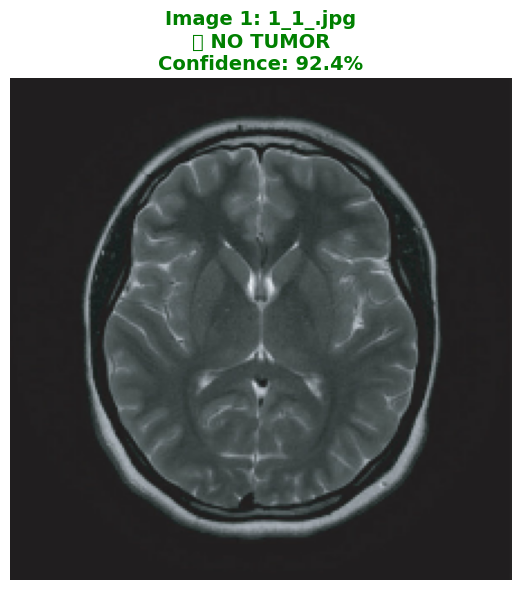

📋 Image 1: 1_1_.jpg
   🎯 Prediction: NO
   📊 Confidence: 92.4%
   💡 Raw score: 0.0755 (>0.5 = tumor)
----------------------------------------


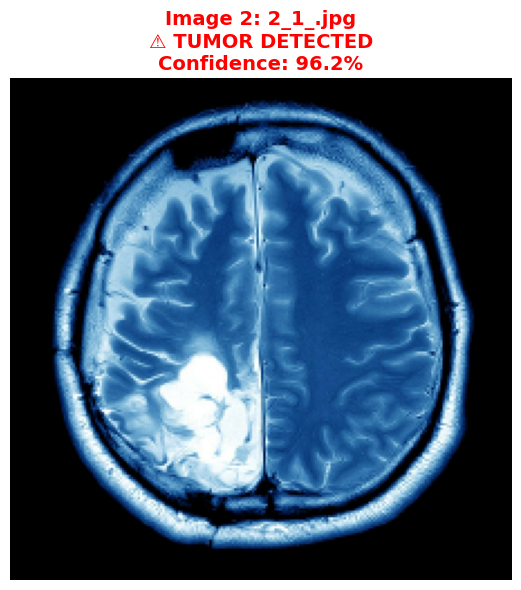

📋 Image 2: 2_1_.jpg
   🎯 Prediction: YES
   📊 Confidence: 96.2%
   💡 Raw score: 0.9623 (>0.5 = tumor)
----------------------------------------


In [28]:
# 🔮 PREDICT ON YOUR UPLOADED IMAGES
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the trained model if not already loaded
try:
    if 'model' not in globals():
        model_path = f"{RESULTS_DIR}/best_model.h5"
        model = tf.keras.models.load_model(model_path, compile=False)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        print(f"✅ Model loaded: {model_path}")

    # Load class names
    try:
        with open(f"{RESULTS_DIR}/class_names.json", 'r') as f:
            class_names = json.load(f)
    except:
        class_names = ["no", "yes"]

    print(f"📊 Model ready! Classes: {class_names}")

    # Check if we have uploaded files
    if 'UPLOADED_FILES' in globals() and UPLOADED_FILES:
        print(f"\n🔮 Making predictions on {len(UPLOADED_FILES)} uploaded image(s):")
        print("=" * 60)

        for i, img_path in enumerate(UPLOADED_FILES, 1):
            try:
                # Load and preprocess image
                img = tf.io.read_file(img_path)
                img = tf.io.decode_image(img, channels=3, expand_animations=False)
                img = tf.image.resize(img, (224, 224))
                img_display = img.numpy().astype(np.uint8)
                img = tf.cast(img, tf.float32) / 255.0
                img = tf.expand_dims(img, axis=0)

                # Make prediction
                pred = model.predict(img, verbose=0)[0][0]
                predicted_class = class_names[1] if pred > 0.5 else class_names[0]
                confidence = pred if pred > 0.5 else 1 - pred

                # Determine result color and emoji
                if predicted_class == "yes":
                    result_color = 'red'
                    emoji = "⚠️"
                    result_text = f"{emoji} TUMOR DETECTED"
                else:
                    result_color = 'green'
                    emoji = "✅"
                    result_text = f"{emoji} NO TUMOR"

                # Display results
                plt.figure(figsize=(8, 6))
                plt.imshow(img_display)
                plt.title(f"Image {i}: {os.path.basename(img_path)}\n{result_text}\nConfidence: {confidence:.1%}",
                         fontsize=14, color=result_color, fontweight='bold')
                plt.axis('off')
                plt.tight_layout()
                plt.show()

                print(f"📋 Image {i}: {os.path.basename(img_path)}")
                print(f"   🎯 Prediction: {predicted_class.upper()}")
                print(f"   📊 Confidence: {confidence:.1%}")
                print(f"   💡 Raw score: {pred:.4f} (>0.5 = tumor)")
                print("-" * 40)

            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")
    else:
        print("❌ No uploaded images found!")
        print("💡 Please run the upload cell above first")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("💡 Please ensure training completed successfully")

### 📋 How to Use:

**Step 1: Run the Upload Cell (Cell 26)**
- Click "Choose Files"
- Select brain MRI images (JPG, JPEG, PNG)
- Wait for upload to complete

**Step 2: Run the Prediction Cell (Cell 27)**
- Automatically loads your trained model
- Makes predictions on uploaded images
- Shows results with confidence scores

**Understanding Results:**
- **✅ NO TUMOR**: Model predicts no brain tumor (score < 0.5)
- **⚠️ TUMOR DETECTED**: Model predicts brain tumor present (score > 0.5)
- **Confidence**: How certain the model is (higher = more confident)
- **Raw Score**: 0.0-1.0 value (closer to 1.0 = more likely tumor)

**Tips for Best Results:**
- Use clear brain MRI images
- Preferably grayscale or similar to training data
- Images will be automatically resized to 224x224 pixels

## 14. Conclusion

This notebook has successfully demonstrated VGG16 transfer learning for brain tumor classification with:

- **VGG16 Model**: Pre-trained ImageNet weights with fine-tuned layers
- **Efficient Training**: Using existing preprocessing and training scripts
- **Comprehensive Evaluation**: Accuracy, precision, recall, F1-score metrics
- **Minimal Code**: Clean, streamlined approach for easy comparison

The model is now ready for comparison with other architectures like CNN, ResNet50, etc.